# Gamma Ray Bursts

Here I do not have target labels, thus mine will be an unsupervised analysis.\
I am searching for a way to cluster my data based on the similarity of the features.\
First I will analyze the features and extract from them as much information as I can (summary statistics and hyperparameters)\
Then I will try yo cluster the data using more features at a time.

In [4]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [5]:
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import brentq

def find_intersection(x, y1, y2):
    """
    Find the intersection point of two lines defined by their y-intercepts and a point on each lin
    Parameters:
    x (float): The x-coordinate of the point where the two lines intersect
    y1 (float): The y-intercept of the first line
    y2 (float): The y-intercept of the second line
    Returns:
    float: The y-coordinate of the intersection point
    """
    
    diff_interp = interp1d(x, y1 - y2, kind='linear', fill_value="extrapolate")

    a, b = x[0], x[-1]
    if diff_interp(a) * diff_interp(b) >= 0:
        raise ValueError("No sign change in interval. Try narrowing the interval or checking data.")

    root = brentq(diff_interp, a, b)

    return root

In [6]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_7284\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [7]:
T90  = data[6]
T90_err = data[7]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [8]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

In [9]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'T_90 ')

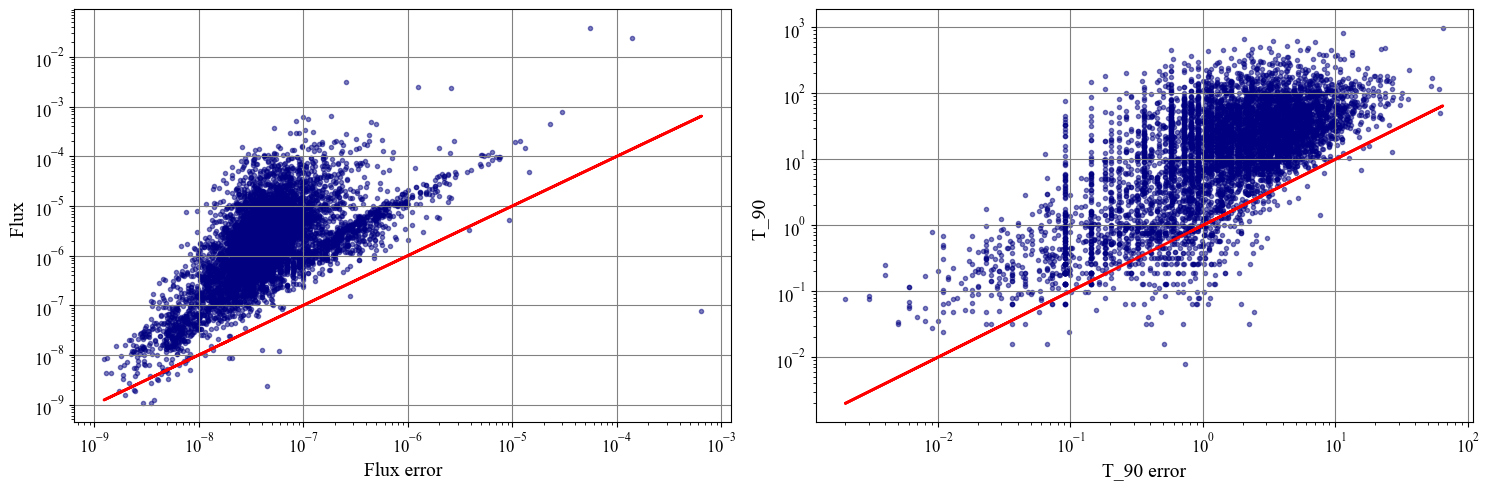

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(Y.T[1], Y.T[0], marker='.', color='navy', alpha=0.5)
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

plt.subplot(1, 2, 2)
plt.scatter(Y.T[3], Y.T[2], marker='.', color='navy', alpha=0.5)
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.\
I can also see a weird effect: there are points lying on lines parallel to the y axis with a $T_{90}$ value ranging from 0.1 to 100! This could be caused by the limited detector resolution. Or it could be that given a $T_{90}$ value, fluence (and thus counting statistic) can vary so much that the error attributed to GRBs with very different $T_{90}$ values could be the same.\
I'll look now into the 1D distributions of T90 and fluence.

In [15]:
def mask2(X):
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    F, Ferr, T90, T90_err = Y.T  
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [16]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask2(X)

Look at one particular feature...

Text(0, 0.5, 'Density')

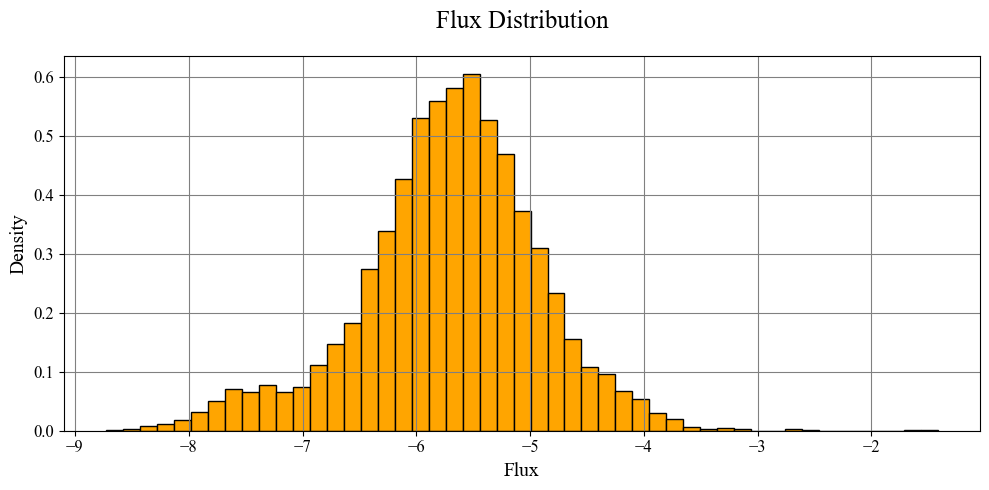

In [17]:
counts, bins,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title('Flux Distribution')
plt.xlabel('Flux')
plt.ylabel('Density')

Seems like there are two gaussians hiding beneath this distribution...I'll use Gaussian Mixture

## Gaussian mixtures

In [54]:
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

In [55]:
train, test = train_test_split(np.log10(Y.T[0]), test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Extract values
n_components_range = [1, 2, 3, 4, 5, 6, 7, 8]
cv = KFold(n_splits=10, shuffle=True, random_state=42)

aic_train, bic_train = [], []
aic_test, bic_test = [], []

# Loop over all parameter settings
for n in n_components_range:
    aic_train_fold, bic_train_fold = [], []
    aic_test_fold, bic_test_fold = [], []

    # Manually perform KFold to compute AIC/BIC
    for train_index, test_index in cv.split(train):
        X_train_cv, X_test_cv = train[train_index].reshape(-1, 1), train[test_index].reshape(-1, 1)
        model = GaussianMixture(n_components=n, random_state=42)
        model.fit(X_train_cv)

        # AIC/BIC on train and test folds
        aic_train_fold.append(model.aic(X_train_cv))
        bic_train_fold.append(model.bic(X_train_cv))
        aic_test_fold.append(model.aic(X_test_cv))
        bic_test_fold.append(model.bic(X_test_cv))

    # Average over folds
    aic_train.append(np.mean(aic_train_fold))
    bic_train.append(np.mean(bic_train_fold))
    aic_test.append(np.mean(aic_test_fold))
    bic_test.append(np.mean(bic_test_fold))

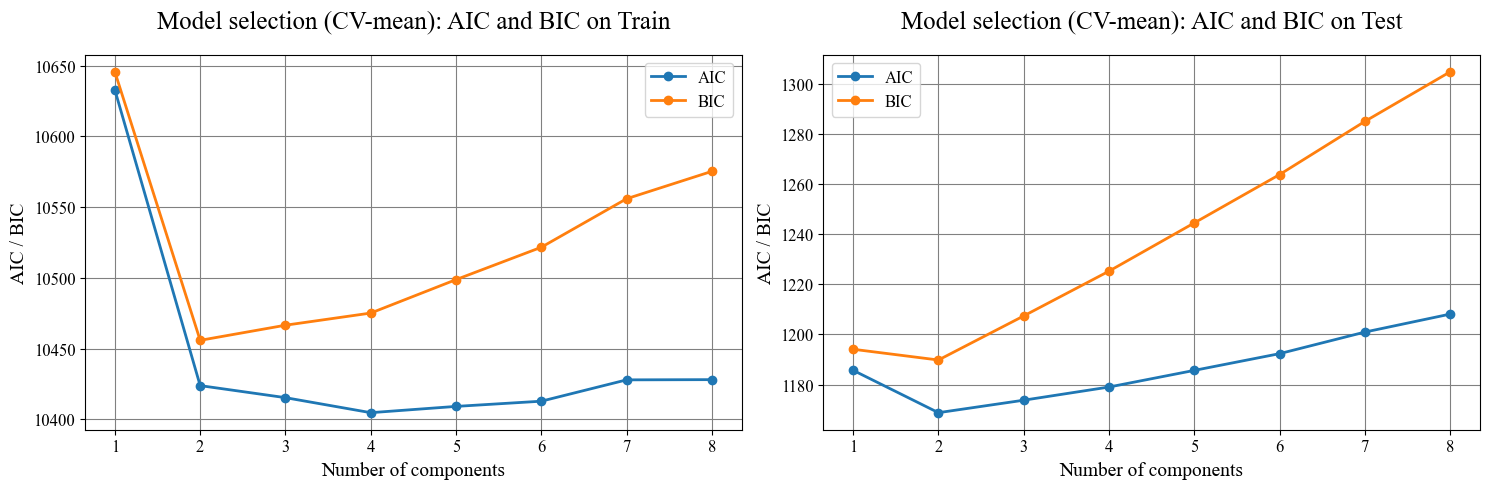

In [57]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_train, label='AIC', marker='o')
plt.plot(n_components_range, bic_train, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection (CV-mean): AIC and BIC on Train")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_test, label='AIC', marker='o')
plt.plot(n_components_range, bic_test, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection (CV-mean): AIC and BIC on Test")

plt.tight_layout()
plt.show()

In [60]:
estimator = GaussianMixture(n_components=2)
estimator.fit(train.reshape(-1,1))

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


In [61]:
print("Test AIC:", estimator.aic(test.reshape(-1, 1)))
print("Test BIC:", estimator.bic(test.reshape(-1, 1)))

Test AIC: 2869.884308304881
Test BIC: 2895.4784395501915


Text(0, 0.5, 'Density')

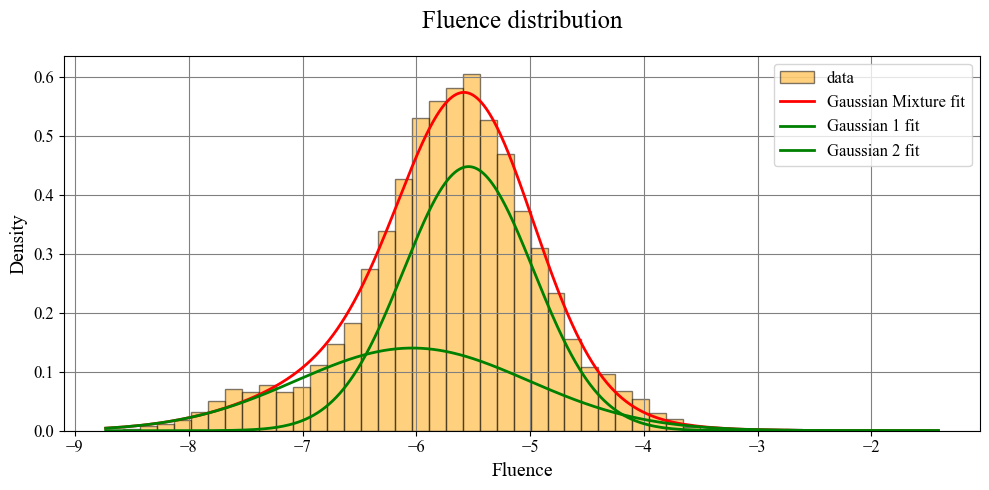

In [62]:
n1 = norm(loc=estimator.means_[0][0],scale=estimator.covariances_[0][0][0]**0.5) 
n2 = norm(loc=estimator.means_[1][0],scale=estimator.covariances_[1][0][0]**0.5) 
labels = estimator.predict(np.log10(Y.T[0]).reshape(-1,1))  

_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[0]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.plot(x, n1.pdf(x)*estimator.weights_[0], lw=2, color='green', label='Gaussian 1 fit')
plt.plot(x, n2.pdf(x)*estimator.weights_[1], lw=2, color='green', label='Gaussian 2 fit')
plt.legend()
plt.title('Fluence distribution')
plt.xlabel('Fluence')
plt.ylabel('Density')

Text(0.5, 1.0, 'Means of gaussians $\\pm \\sigma$ ')

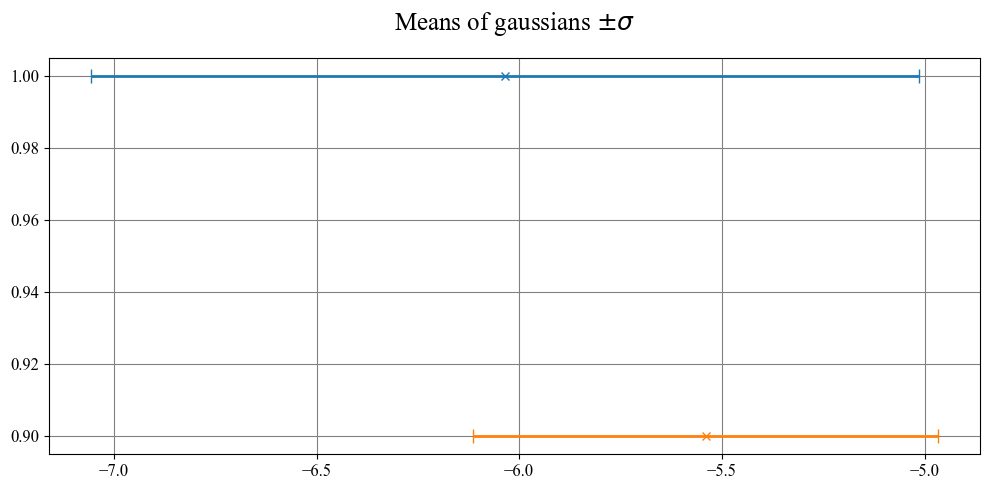

In [63]:
plt.errorbar(estimator.means_[0][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[0][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator', alpha=1)
plt.errorbar(estimator.means_[1][0], 0.9, yerr=None, xerr=np.sqrt(estimator.covariances_[1][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator', alpha=1)
plt.title(r'Means of gaussians $\pm \sigma$ ')

It is evident that there is much overlap bewteen the modes

Text(0, 0.5, 'Density')

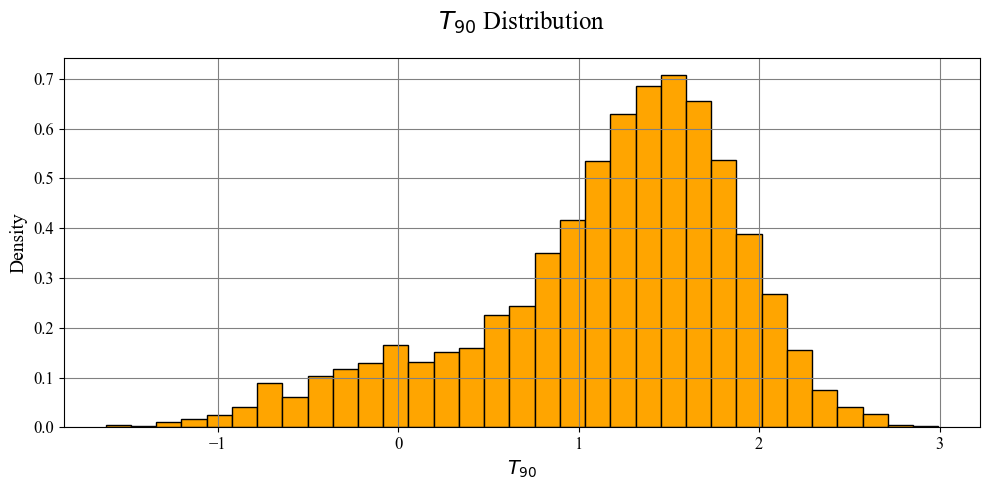

In [64]:
counts, bins, _ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title(r'$T_{90}$ Distribution')
plt.xlabel(r'$T_{90}$')
plt.ylabel('Density')

In [65]:
train, test = train_test_split(np.log10(Y.T[2]), test_size=0.2, shuffle=True, random_state=42)

In [66]:
# Extract values
n_components_range = [1, 2, 3, 4, 5, 6, 7, 8]
cv = KFold(n_splits=10, shuffle=True, random_state=42)

aic_train, bic_train = [], []
aic_test, bic_test = [], []

# Loop over all parameter settings
for n in n_components_range:
    aic_train_fold, bic_train_fold = [], []
    aic_test_fold, bic_test_fold = [], []

    # Manually perform KFold to compute AIC/BIC
    for train_index, test_index in cv.split(train):
        X_train_cv, X_test_cv = train[train_index].reshape(-1, 1), train[test_index].reshape(-1, 1)
        model = GaussianMixture(n_components=n, random_state=42)
        model.fit(X_train_cv)

        # AIC/BIC on train and test folds
        aic_train_fold.append(model.aic(X_train_cv))
        bic_train_fold.append(model.bic(X_train_cv))
        aic_test_fold.append(model.aic(X_test_cv))
        bic_test_fold.append(model.bic(X_test_cv))

    # Average over folds
    aic_train.append(np.mean(aic_train_fold))
    bic_train.append(np.mean(bic_train_fold))
    aic_test.append(np.mean(aic_test_fold))
    bic_test.append(np.mean(bic_test_fold))

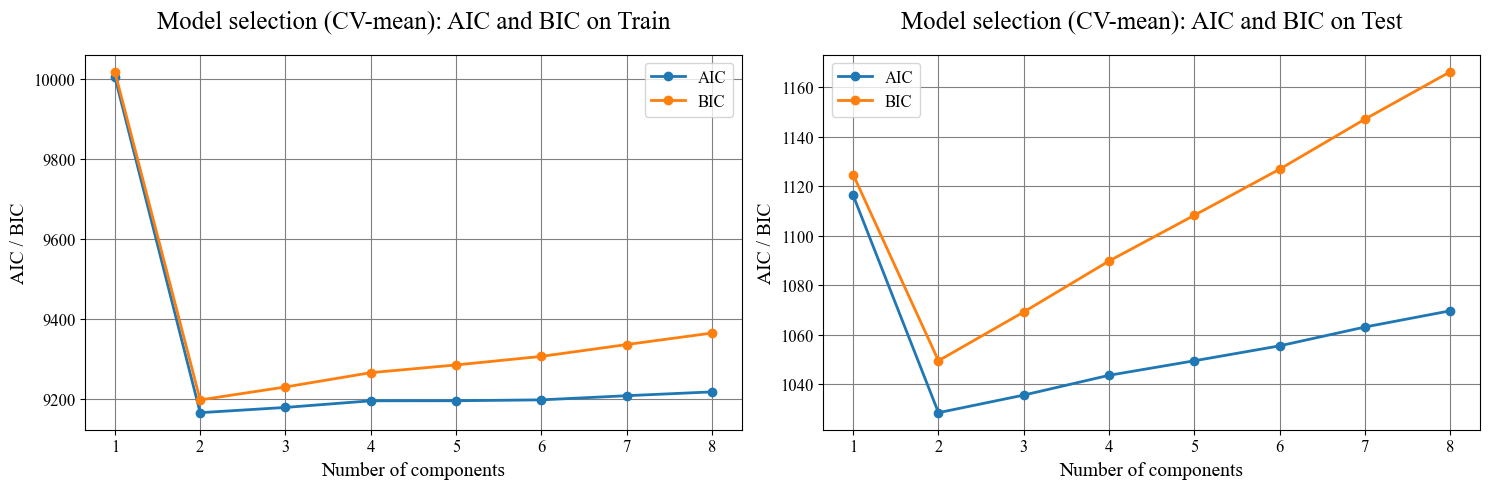

In [67]:
# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_train, label='AIC', marker='o')
plt.plot(n_components_range, bic_train, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection (CV-mean): AIC and BIC on Train")

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_test, label='AIC', marker='o')
plt.plot(n_components_range, bic_test, label='BIC', marker='o')
plt.xlabel("Number of components")
plt.ylabel("AIC / BIC")
plt.legend()
plt.title("Model selection (CV-mean): AIC and BIC on Test")

plt.tight_layout()
plt.show()

In [68]:
estimator = GaussianMixture(n_components=2)
estimator.fit(np.log10(Y.T[2]).reshape(-1,1))

,n_components,2
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


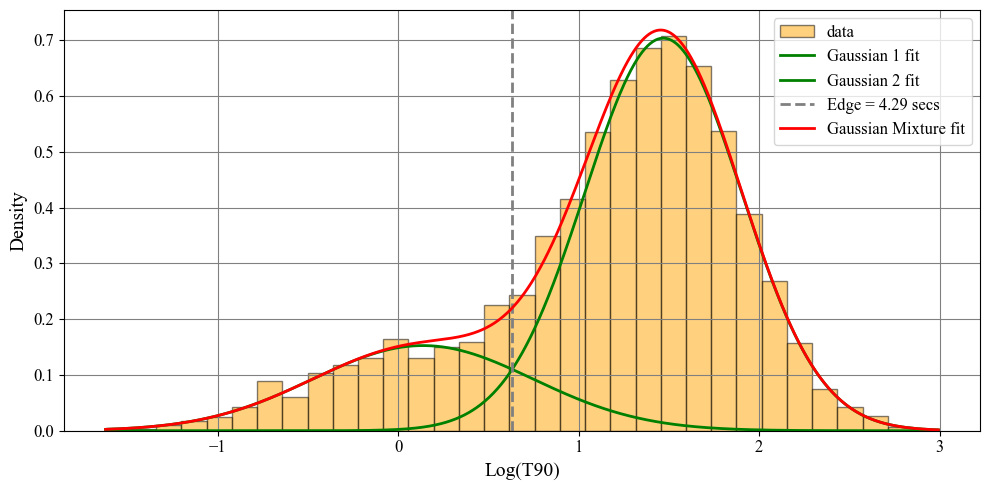

In [69]:
n1 = norm(loc=estimator.means_[0][0],scale=estimator.covariances_[0][0][0]**0.5)
n2 = norm(loc=estimator.means_[1][0],scale=estimator.covariances_[1][0][0]**0.5)

_,_,_ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.linspace(min(np.log10(Y.T[2])),max((np.log10(Y.T[2]))),1000)
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, n1.pdf(x)*estimator.weights_[0], lw=2, color='green', label='Gaussian 1 fit')
plt.plot(x, n2.pdf(x)*estimator.weights_[1], lw=2, color='green', label='Gaussian 2 fit')
edge_gm = find_intersection(x,n1.pdf(x)*estimator.weights_[0],n2.pdf(x)*estimator.weights_[1])
plt.axvline(edge_gm, 0, 1, linestyle='--', color='grey', lw=2 , label=f'Edge = {10**edge_gm:.3} secs')
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.ylabel('Density')
plt.xlabel('Log(T90)')
plt.legend()

Text(0.5, 1.0, 'Means of gaussians $\\pm \\sigma$ ')

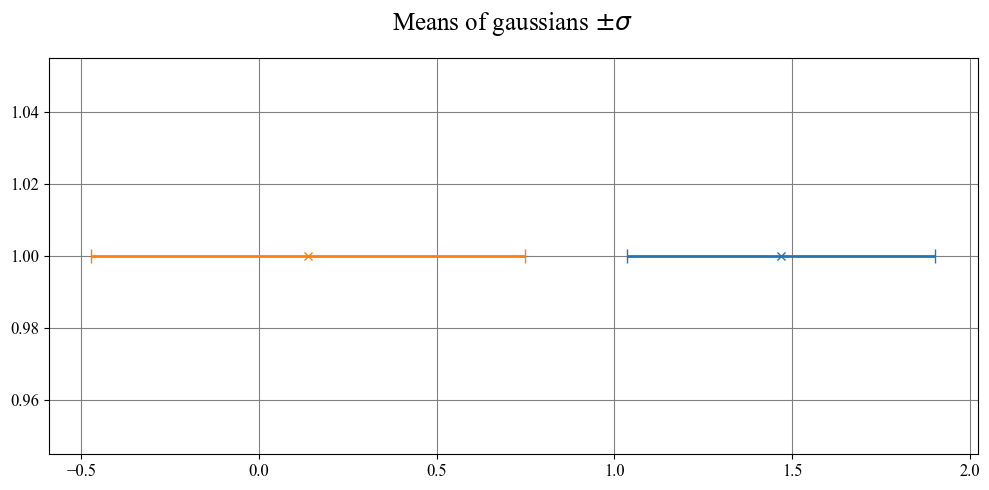

In [70]:
plt.errorbar(estimator.means_[0][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[0][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator')
plt.errorbar(estimator.means_[1][0], 1, yerr=None, xerr=np.sqrt(estimator.covariances_[1][0][0]), fmt='x', barsabove=True, capsize=5, label='Estimator')
plt.title(r'Means of gaussians $\pm \sigma$ ')

In [71]:
labels = estimator.predict(np.log10(Y.T[2]).reshape(-1,1))

**What's the threshold between the classes?**\
$T_{90}$ edge is at $4.29$ seconds

In [72]:
A = np.vstack([np.log10(Y.T[0]),np.log10(Y.T[2])]).T

In [73]:
A_train, A_test = train_test_split(A, test_size=0.2)

In [74]:
gm = GaussianMixture(2, random_state=42)
gm.fit(A_train)
labels = gm.predict(A_test)

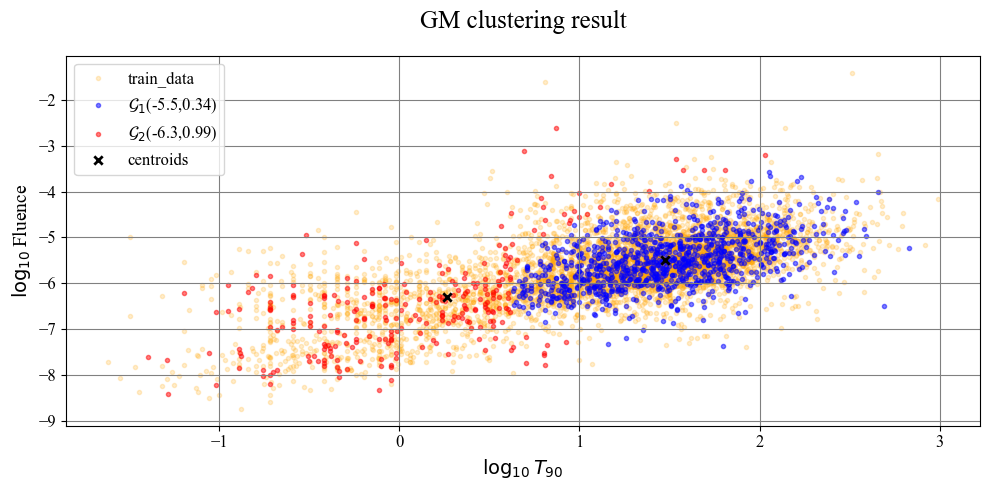

In [80]:
plt.scatter(A_train.T[1],A_train.T[0],marker='.', color='orange', alpha=0.2, label='train_data')
plt.scatter(A_test.T[1][labels==0],A_test.T[0][labels==0],marker='.', color='blue', label=r"$\mathcal{G}_1$"+f'({gm.means_[0][0]:.2},{gm.covariances_[0][0][0]:.2})', alpha=0.5)
plt.scatter(A_test.T[1][labels==1],A_test.T[0][labels==1],marker='.', color='red',  label=r"$\mathcal{G}_2$"+f'({gm.means_[1][0]:.2},{gm.covariances_[1][0][0]:.2})', alpha=0.5)
plt.scatter(gm.means_[:,1],gm.means_[:,0], marker='x', color='black', label='centroids')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('GM clustering result')
plt.legend()

In [81]:
print(f'Cluster 1:  G({10**gm.means_[0]}, {np.diag(gm.covariances_[0])})')
print(f'Cluster 2:  G({10**gm.means_[1]}, {np.diag(gm.covariances_[1])})')

Cluster 1:  G([3.16455258e-06 2.99364819e+01], [0.33861358 0.18800431])
Cluster 2:  G([5.17395165e-07 1.83341896e+00], [0.99132511 0.4716546 ])


**Does the distribution contain different sub-populations? How many?**\
Using GM I found two sub distributions:
 1. Short GRBs with a mean time of $1.73 s$ and a mean fluence of $3.16\times10^{-6} \frac{\text{erg}}{\text{cm}^2}$
 2. Long GRBs with a mean time of $29.73 s$ and a mean fluence of $4.78\times10^{-7} \frac{\text{erg}}{\text{cm}^2}$
 
Thus short GRBs are more frequent then longer ones.

## Mean-Shift

In [101]:
from sklearn.cluster import MeanShift
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

X = A_train 

bandwidths = np.logspace(-3, -1, 5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_bandwidth = None
best_avg_score = -1

for bw in bandwidths:
    print('Fitting bw: ', bw)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        
        # Fit MeanShift on training fold
        model = MeanShift(bandwidth=bw)
        model.fit(X_train)
        labels = model.predict(X_val)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X_val, labels)
            scores.append(score)
    
    if scores:
        avg_score = np.mean(scores)
        print(f'Bandwidth: {bw:.5f}, Avg silhouette score: {avg_score:.4f}')
        
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_bandwidth = bw

print(f'\nBest bandwidth: {best_bandwidth:.5f} with average silhouette score: {best_avg_score:.4f}')


Fitting bw:  0.001
Bandwidth: 0.00100, Avg silhouette score: 0.1045
Fitting bw:  0.0031622776601683794
Bandwidth: 0.00316, Avg silhouette score: 0.1047
Fitting bw:  0.01
Bandwidth: 0.01000, Avg silhouette score: 0.1120
Fitting bw:  0.03162277660168379
Bandwidth: 0.03162, Avg silhouette score: 0.1530
Fitting bw:  0.1
Bandwidth: 0.10000, Avg silhouette score: 0.2188

Best bandwidth: 0.10000 with average silhouette score: 0.2188


In [111]:
ms = MeanShift(bandwidth = 0.5)

In [112]:
labels = ms.fit_predict(A_test)

Text(0.5, 1.0, 'Mean-Shift clustering result')

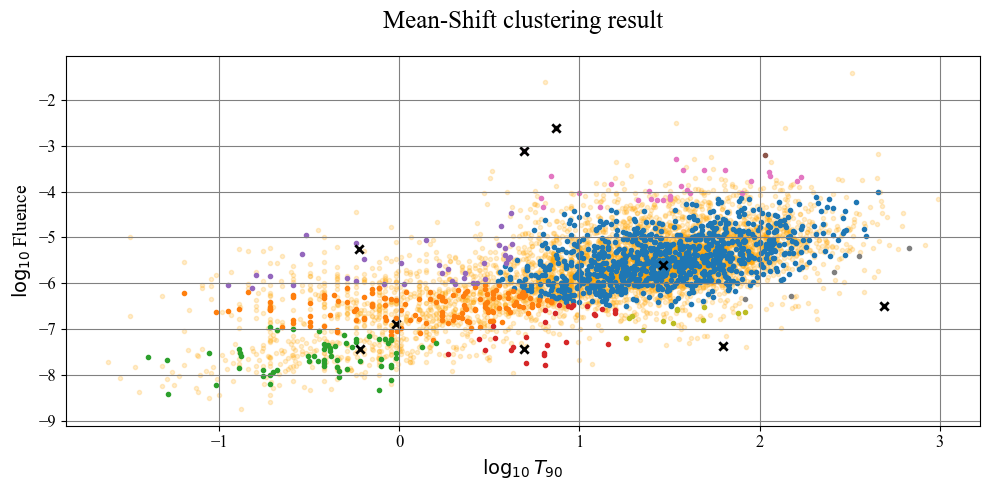

In [113]:
plt.scatter(A_train.T[1],A_train.T[0],marker='.', color='orange', alpha=0.2, label='train_data')
for i in range(len(ms.cluster_centers_)):
    plt.scatter(A_test.T[1][labels==i], A_test.T[0][labels==i], marker='.')
plt.scatter(ms.cluster_centers_[:,1], ms.cluster_centers_[:,0], marker='x', color='black')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('Mean-Shift clustering result')

It is apparent that this method is very sensible to outliers.

## K-Means

$T_{90}$

In [119]:
from sklearn.cluster import KMeans 
from sklearn.model_selection import KFold 
from sklearn.metrics import silhouette_score 

X = A_train 

Ns = [1, 2, 3, 4, 10]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_n = None
best_avg_score = -1

for n in Ns:
    print('Fitting clusters: ', n)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        
        # Fit MeanShift on training fold
        model = KMeans(n_clusters=n)
        model.fit(X_train)
        labels = model.predict(X_val)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X_val, labels)
            scores.append(score)
    
    if scores:
        avg_score = np.mean(scores)
        
        if avg_score > best_avg_score:
            best_avg_score = avg_score
            best_n = n

print(f'\nBest n: {best_n:.5f} with average silhouette score: {best_avg_score:.4f}')

Fitting clusters:  1
Fitting clusters:  2
Fitting clusters:  3
Fitting clusters:  4
Fitting clusters:  10

Best n: 2.00000 with average silhouette score: 0.4955


In [148]:
km = KMeans(n_clusters=2)

In [149]:
km.fit(A_train)
labels = km.predict(A_test)

In [150]:
km.cluster_centers_

array([[-5.36072605,  1.51424907],
       [-6.58373149,  0.24520823]])

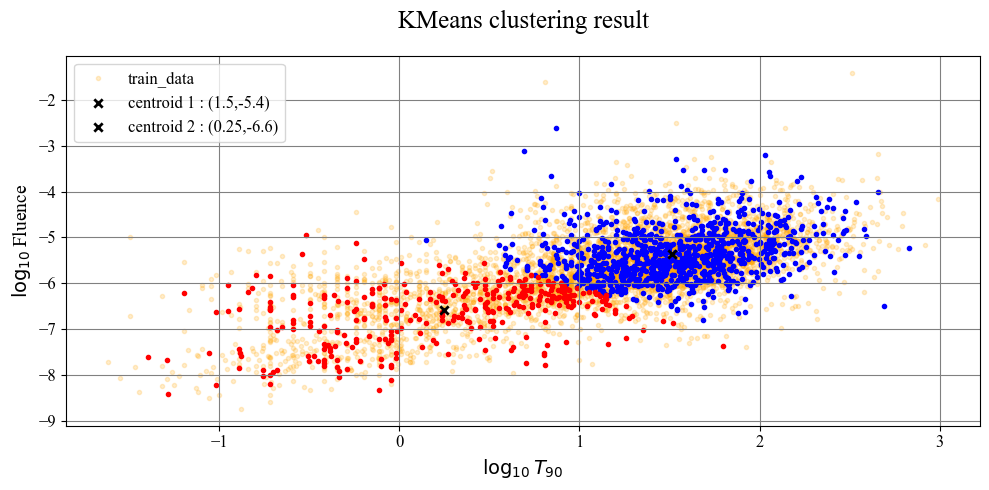

In [168]:
plt.scatter(A_train.T[1],A_train.T[0],marker='.', color='orange', alpha=0.2, label='train_data')
plt.scatter(A_test.T[1][labels==0],A_test.T[0][labels==0],marker='.', color='blue')
plt.scatter(A_test.T[1][labels==1],A_test.T[0][labels==1],marker='.', color='red')
plt.scatter(km.cluster_centers_[0][1],km.cluster_centers_[0][0], marker='x', color='black', 
            label=f'centroid 1 : ({km.cluster_centers_[0][1]:.2},{km.cluster_centers_[0][0]:.2})')
plt.scatter(km.cluster_centers_[1][1],km.cluster_centers_[1][0], marker='x', color='black',
            label=f'centroid 2 : ({km.cluster_centers_[1][1]:.2},{km.cluster_centers_[1][0]:.2})')
plt.xlabel(r'$\log_{10}T_{90}$')
plt.ylabel(r'$\log_{10}$Fluence')
plt.title('KMeans clustering result')
plt.legend()

In [167]:
for i,a in enumerate(['Fluence', 'T90']):
    print(a)
    for l,c,m in zip(['Short GRBs','Long GRBs'],np.sort(km.cluster_centers_[:,i]),np.sort(gm.means_[:,i])):
        print(f"{l}: \t {10**c:.3}, \t {10**m:.3}")

Fluence
Short GRBs: 	 2.61e-07, 	 5.17e-07
Long GRBs: 	 4.36e-06, 	 3.16e-06
T90
Short GRBs: 	 1.76, 	 1.83
Long GRBs: 	 32.7, 	 29.9


In [137]:
train, test = train_test_split(np.log10(Y.T[2]), test_size=0.2, shuffle=True, random_state=42)

In [138]:
km = KMeans(n_clusters=2)

In [144]:
km.fit(train.reshape(-1,1))
labels = km.predict(test.reshape(-1,1))

In [145]:
edge_km = 10**np.mean([np.sort(test[labels==0]).min(),np.sort(test[labels==1]).max()])
print(f'Edge = {edge_km:.3} seconds')

Edge = 4.86 seconds


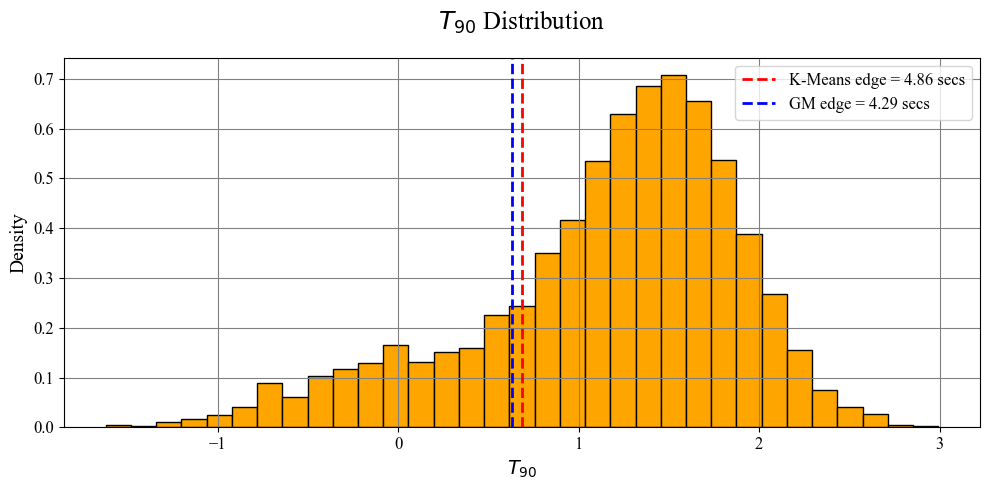

In [146]:
counts, bins, _ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.axvline(np.log10(edge_km),0,1,linestyle='--', color='red', lw=2, label=f'K-Means edge = {edge_km:.3} secs')
plt.axvline(edge_gm,0,1,linestyle='--', color='blue', lw=2., label=f'GM edge = {10**edge_gm:.3} secs')
plt.title(r'$T_{90}$ Distribution')
plt.xlabel(r'$T_{90}$')
plt.ylabel('Density')
plt.legend()